In [218]:
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
import pandas as pd
from transformers import BertTokenizer, AlbertTokenizer, XLNetTokenizer, GPT2Tokenizer, LongformerTokenizer

import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from wordcloud import WordCloud, STOPWORDS
import re
import itertools

import nlpaug.augmenter.word as naw
import nlpaug.model.word_stats as nmw
from googletrans import Translator
from langdetect import detect
from httpcore._exceptions import ProtocolError

from nlpaug.util import Action
from nlpaug.util.file.download import DownloadUtil as dutil

import numpy as np
import math
import time

import os
from tqdm.notebook import tqdm
import logging
from IPython.core.debugger import set_trace

%run -i "../news-topic-cls/core/models/base.py"
%run -i "../news-topic-cls/core/models/extension.py"
%run -i "../news-topic-cls/core/data/data.py"
%run -i "../news-topic-cls/core/utils/optim.py"
%run -i "../news-topic-cls/core/utils/utils.py"
%run -i "../news-topic-cls/core/data/augmentation.py"
%run -i "../news-topic-cls/core/data/augment_dataframe.py"

No Apex Import


### Results of SVM Benchmark

In [194]:
import json
with open("/Users/bradloff/Documents/masterthesis/devex/monkeylearn_gold_standard_evaluation-news-topics_articles.json", "r") as cls_eval:
    evals = json.load(cls_eval)

In [295]:
tp = 0
fp = 0
fn = 0
tn = 0
labels = ["ED"]
for key, value in evals["category_results"].items():
    if key[1:3] in labels:
        tp += value["tp"]
        fn += value["fn"]
        fp += value["fp"]
        tn += (77 - value["tp"] - value["fn"] - value["fp"])

recall = tp/(tp+fp)
prec = tp/(tp+fn)

f1 = 2*(recall*prec)/(prec+recall)
mcc = (tp * tn - fp * fn)/math.sqrt((tp + fp)*(tp+fn)*(tn+fp)*(tn+fn))

print(f1, prec, recall, mcc)

0.3333333333333333 0.5 0.25 0.24523251799691578


In [288]:
all_labels = ['AG', 'BF', 'CE', 'ED', 'EN', 'FU', 'GH', 'HA', 'HR', 'ID', 'II', 'IN', 'MC', 'NR', 'PM', 'PS', 'RE', 'SD', 'TP', 'UD', 'WS']

In [361]:
overall_acc = 1.0
for label in all_labels:
    correct = 0
    labels = [label]
    for result in evals["sample_results"]:
        preds = [cls[1:3] for cls in result["classifications"]]
        targets = [tar[1:3] for tar in result["gold_standard_classifications"]]

        filtered_preds = [pred for pred in preds if pred in labels]
        filtered_targets = [target for target in targets if target in labels]

        if sorted(filtered_preds) == sorted(filtered_targets):
            correct += 1
    acc = correct/77
    overall_acc *= acc
    print("Accuracy Single-Label-{}: {}".format(label, acc))
print("-----------------------------")
print("Overall estimated Accuracy: {}".format(overall_acc))

Accuracy Single-Label-AG: 0.922077922077922
Accuracy Single-Label-BF: 0.8961038961038961
Accuracy Single-Label-CE: 0.935064935064935
Accuracy Single-Label-ED: 0.7922077922077922
Accuracy Single-Label-EN: 0.922077922077922
Accuracy Single-Label-FU: 0.8311688311688312
Accuracy Single-Label-GH: 0.935064935064935
Accuracy Single-Label-HA: 0.8831168831168831
Accuracy Single-Label-HR: 0.8961038961038961
Accuracy Single-Label-ID: 0.9090909090909091
Accuracy Single-Label-II: 0.8831168831168831
Accuracy Single-Label-IN: 0.8831168831168831
Accuracy Single-Label-MC: 0.935064935064935
Accuracy Single-Label-NR: 0.8701298701298701
Accuracy Single-Label-PM: 0.948051948051948
Accuracy Single-Label-PS: 0.8311688311688312
Accuracy Single-Label-RE: 0.961038961038961
Accuracy Single-Label-SD: 0.8311688311688312
Accuracy Single-Label-TP: 0.8051948051948052
Accuracy Single-Label-UD: 0.948051948051948
Accuracy Single-Label-WS: 0.961038961038961
-----------------------------
Overall estimated Accuracy: 0.0924

In [286]:
correct = 0
labels = ["UD"]
for result in evals["sample_results"]:
    preds = [cls[1:3] for cls in result["classifications"]]
    targets = [tar[1:3] for tar in result["gold_standard_classifications"]]
    
    filtered_preds = [pred for pred in preds if pred in labels]
    filtered_targets = [target for target in targets if target in labels]
    
    if sorted(filtered_preds) == sorted(filtered_targets):
        correct += 1
print("Accuracy Single-Label: {}".format(correct/77))

correct = 0
labels = ['FU', 'GH', 'TP', 'SD', 'ID']
for result in evals["sample_results"]:
    preds = [cls[1:3] for cls in result["classifications"]]
    targets = [tar[1:3] for tar in result["gold_standard_classifications"]]
    
    filtered_preds = [pred for pred in preds if pred in labels]
    filtered_targets = [target for target in targets if target in labels]
    
    if sorted(filtered_preds) == sorted(filtered_targets):
        correct += 1
print("Accuracy 5-Labels: {}".format(correct/77))

correct_cls = 0
for value in evals["sample_results"]:
    if sorted(value["gold_standard_classifications"]) == sorted(value["classifications"]):
        correct_cls += 1
print("Accuracy 21-Labels: {}".format(correct_cls/77))

Accuracy Single-Label: 0.948051948051948
Accuracy 5-Labels: 0.42857142857142855
Accuracy 21-Labels: 0.06493506493506493


### Averaging Metrics for Training Runs

In [64]:
def average_metrics(acc=[], f1=[], prec=[], rec=[], mcc=[], loss=[]):
    if acc!=[]:
        print("Accuracy: {}".format(np.array(acc).mean()))
    if f1!=[]:
        print("F1: {}".format(np.array(f1).mean()))
    if prec!=[]:
        print("Precision: {}".format(np.array(prec).mean()))
    if rec!=[]:
        print("Recall: {}".format(np.array(rec).mean()))
    if mcc!=[]:
        print("MCC: {}".format(np.array(mcc).mean()))
    if loss!=[]:
        print("Loss: {}".format(np.array(loss).mean()))

In [370]:
acc = [0.7685, 0.8631, 0.8144, 0.857, 0.8288]
f1 = [0.3807, 0.4574, 0.4759, 0.5415, 0.4648]
prec = [0.2614, 0.3493, 0.341, 0.4688, 0.3646]
rec = [0.7, 0.6623, 0.7872, 0.641, 0.6408]
mcc = [0.3233, 0.4137, 0.4343, 0.4668, 0.3925]
loss = [0.2976, 0.2345, 0.2862, 0.2511, 0.2816]

In [371]:
average_metrics(acc=acc, f1=f1, prec=prec, rec=rec, mcc=mcc, loss=loss)

Accuracy: 0.82636
F1: 0.46406000000000003
Precision: 0.35702
Recall: 0.68626
MCC: 0.40612000000000004
Loss: 0.2702


## Data 

In [372]:
data_path = "../data/article_confirmed.csv"
if "test" in data_path:
    df = pd.read_csv(data_path).drop(labels="Unnamed: 0", axis=1)
else:
    df = pd.read_csv(data_path)
df, label_encoder = encode_labels(df)
abbrev_mapping = get_abbreveation_mapping(label_encoder)
df = binarize_labels(df, abbrev_mapping)
df.head()
original_df = df

In [373]:
len(df)

4425

In [374]:
config_name = "roberta-base"
transformer = TransformerOptions(config_name)

# Data Engineering

In [375]:
print("Original Length: {}".format(len(original_df)))

Original Length: 4425


In [376]:
def clean_data(dataframe):
    id_list = [62094]
    cleaned_df = dataframe[~dataframe.id.isin(id_list)]
    """
    event_preview_ids = []
    for index, row in tqdm(dataframe.iterrows()):
        if row.text[:15] == "Events preview:":
            event_preview_ids.append(row.id)
    long_enumeration_ids = [94003]
    cleaned_df = cleaned_df[~cleaned_df.id.isin(long_enumeration_ids + event_preview_ids)]
    """
    cleaned_df.replace("<.*>", "", regex=True, inplace=True)
    return cleaned_df

In [377]:
df = clean_data(original_df)
len(df)

/opt/anaconda3/envs/thesis/lib/python3.7/site-packages/pandas/core/frame.py:4172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


4424

In [378]:
class IncreasedLoggingLevel():
    def __init__(self, logger_name, target_level=logging.ERROR):
        self.logger = logging.getLogger(logger_name)
        self.target_level = logging.ERROR
        self.original_level = self.logger.getEffectiveLevel()
    def __enter__(self):
        self.logger.setLevel(self.target_level)
    def __exit__(self, type, value, traceback):
        self.logger.setLevel(self.original_level)        

In [379]:
with IncreasedLoggingLevel("transformers.tokenization_utils_base") as x:
    input_ids = [transformer.tokenizer(text)["input_ids"] for text in df.text.values]

### Spell Checker

In [ ]:
from spellchecker import SpellChecker

In [ ]:
is_id = df.id == 85826
article = df[is_id].text.values[0]

In [ ]:
words = nltk.word_tokenize(article)

In [ ]:
checker = SpellChecker()
checker.unknown(words)

In [ ]:
text = "Below is a nonexhaustive selection of some of the city’s most prominent INGOs working to support development: Amnesty International Founded: 1961 Director: Kate Allen Annual budget: 24.8 million pounds (\$36.9 million) Staff: 170 across the U.K. Activities: human rights, advocacy The name Amnesty International has long been associated with human rights and justice for those whose rights have been violated around the world."
tokens = transformer.tokenizer.tokenize("diarrhea")

In [ ]:
tokens

### Long Enumerations

In [434]:
def postprocess_sentences(sentences):
    for index, sentence in enumerate(sentences):
        if sentence.count(",") > 15:
            tokens = nltk.word_tokenize(sentence)
            word_counter = len(tokens)
            if word_counter >= 200:
                sentences[index] = "List of upcoming events."

    return sentences

def sentenize(article):
    sentences = nltk.tokenize.sent_tokenize(article)
    for index, sentence in enumerate(sentences):
        quotes = find_quotes(sentence)
        sentences[index] = quotes

    def flatten(list_): return [item for sublist in list_ for item in sublist]
    return flatten(sentences)

def find_quotes(sentence):
    condition = re.compile(".*?”")
    matches = condition.finditer(sentence)
    quotes = [match.group().strip() for match in matches]
    if quotes == []:
        return [sentence]
    last_match = quotes[-1]
    lower_bound = sum([len(quote) for quote in quotes]) - len(last_match)
    last_match_end = sentence.find(last_match, lower_bound) + len(last_match)
    after_quotes = sentence[last_match_end:].strip()
    if after_quotes != "":
        quotes.append(after_quotes)
    return quotes

In [435]:
is_id = df.id == id_
article = df[is_id].text.values[0]
sentences = sentenize(article)

In [462]:
id_ = 94029
print_article_with_labels(id_=id_)

ID: 94029
_____________________
Long Story Short #39: What COP24 means for global development Guests: Michael Igoe, senior reporter and Andrew Green, freelance contributor Host: Kate Midden, engagement editor This year’s United Nations climate talks in Katowice have raised major questions about the influence of fossil fuel companies on global climate policy, the ability of negotiators to push forward an ambitious climate agenda, and the fortitude of the Paris Agreement. Against a conflicting backdrop of alarming new climate science and pro-coal superpowers working against the tide of progress, the fate of the Paris Rulebook — the guiding document for implementing the Paris Agreement — hangs in the balance. From the heart of Polish coal country, Devex’s Michael Igoe, Andrew Green, and Kate Midden explore major stories from the Conference of Parties so far — and what this year’s negotiations mean for global development. Additional reading: • 4 things to watch at COP24 • Activists sound a

In [446]:
id_ = 93200
print_article_with_labels(id_=id_)

ID: 93200
_____________________
Long Story Short #23: Inside the global HIV/AIDS response Check out the video of this episode on our Facebook page. Want to listen to this episode on the go? Listen and subscribe: iTunes | SoundCloud Guests: Mercy Ngulube, youth advocate and trustee, Sophia Forum Sophie Edwards, reporter, Devex Host: Kate Midden, engagement editor, Devex Ahead of the International AIDS conference in Amsterdam, experts warned that progress on HIV/AIDS is stalling. What’s behind the concerning trend — and what will it take to get on track to meet ambitious targets for 2020 and 2030? Live from AIDS 2018, this conversation covers the top stories to watch in the HIV/AIDS response — from youth engagement to integration of programming with tuberculosis, sexual and reproductive health, and more. Additional reading: • The 'end of AIDS' is not even nearly in sight, experts warn • Launch of $1.2B coalition to expand HIV services for men • UNAIDS chief confronted by anti-harassment 

In [447]:
id_ = 94029
print_article_with_labels(id_=id_)

ID: 94029
_____________________
Long Story Short #39: What COP24 means for global development Guests: Michael Igoe, senior reporter and Andrew Green, freelance contributor Host: Kate Midden, engagement editor This year’s United Nations climate talks in Katowice have raised major questions about the influence of fossil fuel companies on global climate policy, the ability of negotiators to push forward an ambitious climate agenda, and the fortitude of the Paris Agreement. Against a conflicting backdrop of alarming new climate science and pro-coal superpowers working against the tide of progress, the fate of the Paris Rulebook — the guiding document for implementing the Paris Agreement — hangs in the balance. From the heart of Polish coal country, Devex’s Michael Igoe, Andrew Green, and Kate Midden explore major stories from the Conference of Parties so far — and what this year’s negotiations mean for global development. Additional reading: • 4 things to watch at COP24 • Activists sound a

In [459]:
id_ = 94178
print_article_with_labels(id_=id_)

ID: 94178
_____________________
Satellites for Sustainability: A deeper look Space technologies are increasingly important to address some of the most pressing global challenges. Over the past year, Devex has explored three humanitarian and development projects harnessing satellite communications technology for impact — from disaster response to digital health and sustainable fishing. Revisit our coverage in this visual feature. Read more about the impact of satellites in development work on our Satellites for Sustainability site.
_____________________
Labels:
Innovation & ICT
Media And Communications
Private Sector


In [454]:
text = "Brazil as an Emerging Donor: Huge Potential and Growing Pains EDITOR’S NOTE: Considered an emerging donor, Brazil has focused its aid program on Africa, with nearly 40 percent of its technical cooperation grants in 2009 benefiting 19 African countries, according to Paulo Sotero, director of the Brazil Institute at the Woodrow Wilson International Center for Scholars. It follows a philosophy that differs considerably from other donors, even with fellow emerging economies such as China, because its development cooperation is not motivated by economic interests. A few excerpts: President Luiz Inacio Lula da Silva could not hide his disappointment when he visited Maputo, last October (2008). He had expected to see signs of progress in the construction of a $23 million plant to produce generic drugs for the treatment of HIV/AIDS, which his administration had donated to Mozambique. As the most ambitious foreign assistance project ever launched by Brazil, the plant’s project was announced with some fanfare during the Brazilian president’s first visit to Maputo, in 2003. It was to have been built in four phases, with an operational start date in 2010, Lula’s last year in office. Brazil allocated $4 million for the project’s first phase. The project was launched on the basis of Brazil’s international stature as a model country in the combat of HIV/AIDS, earned as a result of the work of the Oswaldo Cruz Foundation, known as Fiocruz, which is attached to the country’s Ministry of Health. Bringing the project to Africa, the continent most afflicted by the AIDS pandemic, was a bold political decision on the part of the current Brazilian administration, calculated to give meaning and substance to Lula’s government strategy to expand Brazil’s presence in the southern hemisphere. Five years later, there was nothing to be measured or seen. During a closed-door meeting with Mozambican president Armando Ermílio Guebuza, Lula blamed the slow pace of the project’s implementation on his own Ministry of External Relations, which coordinates foreign assistance in the federal government through its Agência Brasileira de Cooperação, or ABC. Speaking at the inauguration of a Maputo office of Fiocruz, Lula promised that, in the event of any future obstacles, “we shall clear the path, we shall unblock matters so that we can come to Mozambique in 2010 and definitively inaugurate the Fiocruz laboratory and the anti-retroviral factory.” The plant, planned for the southern Mozambican city of Matola, is to supply AIDS drugs across Africa. To leave no doubt about the president’s frustration with his government’s poor management of the project, Lula’s office played the tape of his conversation with Guebuza to the Brazilian journalists covering the trip. Virtues and challenges The episode is emblematic of both the virtues and the challenges confronting Brazil as an emerging provider of international assistance, alongside China, India, South Africa and a few others. The Matola project involves an area in which Brazil, a developing country still struggling to reduce poverty and inequality, has achieved success and has knowledge to share with other developing countries on issues that really matter to them. In this sense, it reflects the spirit of genuine solidarity that guides Brazil’s foreign assistance. It also indicates a social and political—rather than economic—motivation in Brazilian international cooperation initiatives. Farmanguinhos, a Fiocruz laboratory, will supply the technology and training for the production of the anti-retroviral drugs in Matola. The chemicals and other ingredients will come in part from India, which has worked with Brazil and South Africa to bring a developing nation’s vision and sensitivity to poverty reduction and other matters of interest to the nations of the southern hemisphere. “What is striking about the current portfolio of commitments made by ABC is that it doesn’t show commercial and/or business interests. Just the opposite, the commitments respond to demands made by the government of recipient countries to the Brazilian Ministry of Foreign Affairs,” says Maristela Baioni, the Program Coordinator for the United Nations Development Program (UNDP) in Brasilia. “A portfolio review shows that no links can be established between the growing number of Brazilian global companies now bringing investments and providing services in Latin America, Africa and parts of Asia and the technical cooperation promoted by the government of Brazil.” In this sense, Brazil international cooperation contrasts with the tied-aid of the traditional model of North-South cooperation and even with the policies of other BRIC countries, such as China. “Another important contrast is that Brazilian South-South cooperation provides technical assistance with a much better understanding of development contexts than traditional North-South cooperation. Brazilian experience, expertise and training transferred to Portuguese speaking countries have the comparative advantage of sharing common language and cultural aspects,” notes Baioni. “This makes Brazilian foreign assistance initiatives both innovative and welcome by the beneficiary countries—with greater chances of being effective when implemented.” The country’s traditional emphasis on technical cooperation and its active high-technology sector has contributed to give to Brazilian development assistance a more significant and focused development dimension, according to Dane Rowlands, of Carleton University’s Norman Paterson School of International Affairs, in Ottawa. Rowlands summarized the qualities and deficiencies of Brazil’s foreign assistance in a comparative study of emerging donors published last year by the International Development Research Center. “India and China have been reluctant to collaborate extensively with foreign partners due to the fear of losing policy independence,” he wrote in a recent paper. “Brazil and South Africa have been much more cooperative in their overall development programs, as well as in research for development.” In Rowlands’ view, the original motivations and strategic objectives of Brazil’s assistance efforts also set the country apart. These, however, are evolving. “In contrast to China and India, Brazil’s development assistance program seemed to emerge more directly from its affinity with other less developed countries and less from immediate political or diplomatic ambitions,” he wrote. While Brasilia does respond to strong pressures to give priority to its immediate neighbors in order to increase its influence and elevate its profile in regional affairs, its assistance program was expanded to other regions as the country’s global stature increased. Brazil’s initiatives Indeed, Africa—more than Latin America—has become the focus of Brazil’s initiatives as an emerging donor. Of its 318 technical cooperation initiatives abroad, 125 involve programs in 19 African countries, namely Angola, Algeria, Benin, Botswana, Burkina-Faso, Cape Verde, Cameron, Egypt, Gambia, Guinea-Bissau, Mali, Morocco, Mozambique, Namibia, Nigeria, Kenya, San Tome & Principe, Senegal, Zambia and Zimbabwe. The total investment by the Brazilian government has amounted to slightly more than half of the $22 million it allotted to such programs. In comparison, Brazil lists 119 projects with its nine immediate neighbors in South America, plus Ecuador. Another 22 cooperation projects are in other South American countries and 58 activities carried out with Belize, Costa Rica, El Salvador, Honduras, Nicaragua, Panama, Cuba, Haiti, Jamaica, Dominican Republic, as well as nine Caribbean countries. Brazil’s international cooperation initiatives have also been extended to Timor Leste, a former Portuguese colony, and to Lebanon, the country of origin of most of the estimated 10 million Brazilians of Arab ancestry. According to ABC, the bulk of Brazil’s international cooperation, measured by cost, involves professional qualification in recipient countries (22 percent) in the two areas where Brazilian development activities have produced impressive outcomes at home: health (18 percent) and agriculture and livestock (15 percent). Other fields include education (10 percent), social development (7 percent) and legislative assistance (6 percent). The more challenging aspect of Brazil as an emerging donor is the dispersion of its aid, reflected in the number of initiatives and the variety of fields covered. The problem is compounded by the multiplicity of agencies involved in the implementation and an insufficient cadre of international cooperation experts at ABC. The technical knowledge available at the agency is provided mostly through a cooperative relationship with the Brasilia office of the UNDP. Divided into seven coordinating units headed by professional diplomats whose assignments change every three or four years, ABC also suffers from a lack of both administrative autonomy and political clout. Knowledgeable sources also see the need for better coordination among the various agencies involved in the planning and execution of projects. The rapid expansion of Brazil’s international cooperation activities under the Lula government has highlighted these shortcomings. They do not diminish, however, the essentially positive nature of Brazil’s development outreach and its promising impact in the beneficiary nations. Re-published with permission by the World Bank. Visit the original article."

In [455]:
len(nltk.word_tokenize(text))

1640

In [464]:
labels = ['AG', 'BF', 'CE', 'ED', 'EN', 'FU', 'GH', 'HA', 'HR', 'ID', 'II', 'IN', 'MC', 'NR', 'PM', 'PS', 'RE', 'SD', 'TP', 'UD', 'WS']

for index, row in df.iterrows():
    active_labels = [label for label in labels if row.loc[label]==1]
    word_counter = len(nltk.word_tokenize(row.text))
    if len(active_labels) > 1 and word_counter <= 200 and word_counter >= 100:
        #print(active_labels)
        print_article_with_labels(id_=row.id)
        print("-----------------")

ID: 45755
_____________________
North Korea Gets Food Aid from Germany Germany answered the World Food Program?s petition for aid to feed starving people in North Korea. German Development Minister Heidemarie Wieczorek-Zeul announced that Berlin is contributing $620,000 to the operations of the United Nations food agency in the communist state, which the minister said had to cut daily rice handouts to 40 percent of the minimum recommended calories as per international standards. According to Wieczorek-Zeul, "the North Korean people are threatened by a famine similar to the one it suffered in 1990." The WFP estimated that undernourishment plagues over half of the 23.7 million people living the Asian country. Source: Germany offers food aid to North Korea (AFP)
_____________________
Labels:
Agriculture & Rural Development
Humanitarian Aid
-----------------
ID: 58663
_____________________
IDB Aid to Promote Clean Energy in Caribbean Caribbean nations will benefit from four Inter-American 

ID: 89826
_____________________
Transitioning to a global development job? Here's how to write your CV While the global development sector is highly competitive, a growing demand for specific skills and expertise is creating job opportunities for transitioning professionals from a range of backgrounds. CV expectations for jobs in global development differ from that of other sectors. If you are trying to make the move into a career in the sector, make sure your CV is not holding you back. Here are some top tips for writing a CV and translating your experience for the global development sector. Looking to make a career move? Visit our career center for expert advice on how to navigate your job search — all you need is a Devex Career Account to get started.
_____________________
Labels:
Careers & Education
Economic Development
Project Management
-----------------
ID: 91675
_____________________
Digital Event: Inside the investigation of USAID's $9.5B health project WASHINGTON — In 2016, C

ID: 93117
_____________________
Long Story Short #21: The biggest trends in impact investing Check out the video of this episode on our Facebook page. Want to listen to this episode on the go? Listen and subscribe: iTunes | SoundCloud Guests: Adva Saldinger, associate editor, Devex Host: Amy Lieberman, reporter, Devex In the face of increasing uncertainty from traditional donors — and a looming 2030 deadline for achieving the Sustainable Development Goals — the development industry is looking to private investors to finance development. One of the fastest-growing practices? Impact investing. On the heels of the Vatican Impact Investing Conference, reporter Amy Lieberman and associate editor Adva Saldinger discuss what impact investing has accomplished, how it’s evolving, and what’s in store next. Additional reading: • Impact investing growth continues as industry begins tracking to SDGs • Can a UN social impact fund spark further reform at the organization? • Leveraging impact investin

ID: 93399
_____________________
Long Story Short #26: What global development can learn from Nike Check out the video of this episode on our Facebook page. Want to listen to this episode on the go? Listen and subscribe: iTunes | SoundCloud Guest: Carine Umuhumuza, Devex associate director for communications Host: Kate Midden, Devex engagement editor In honor of 30 years of #JustDoIt, Nike unveiled a controversial new face for its signature campaign: Activist and former NFL quarterback Colin Kaepernick. Announced with a simple tweet, the move generated an outpouring of online responses, leading to an estimated $43 million in free advertising for the company. What can global development learn from Nike’s high-risk, high-return campaign refresh? In this episode, Devex communications guru Carine Umuhumuza shares four key lessons for organizations working to create engaging, share-worthy content. Additional reading: • On Message: Creating community with intention • PATH's rebrand: A scalabl

ID: 93691
_____________________
Long Story Short #32: Responding to Indonesia's dual disaster Listen to this episode: on iTunes | on SoundCloud Guest: Kelli Rogers, Devex Asia correspondent Host: Deborah Charles, Devex news editor Late last month, a devastating dual disaster struck the Indonesian island of Sulawesi. Thousands were injured and tens of thousands required assistance following the magnitude 7.5 earthquake and tsunami featuring 6-meter high waves hitting communities in Palu and Dongala. The subsequent devastation has proved challenging for the response and raised questions about the country’s disaster preparedness. In this episode, Asia Correspondent Kelli Rogers and News Editor Deborah Charles discuss what unfolded, how the catastrophe compared to others in the disaster-prone Asia-Pacific region — and what it means for disaster resilience and preparedness moving forward. Additional reading: • Indonesia disaster reveals community preparedness shortfalls • In Palu, relief te

ID: 96016
_____________________
DevExplains: The Overseas Contingency Operations account and its role in US aid funding WASHINGTON — The Overseas Contingency Operations account is a somewhat obscure mechanism that has proven to be a critical tool in maintaining the international affairs budget in the United States. The account, originally intended to help the Department of Defense pay for the wars in Iraq and Afghanistan, is considered an emergency account and is not subject to the budget caps imposed on U.S. appropriators. In the years since its creation, the OCO account has been used for an increasingly broad range of U.S. programs, and even some of the U.S. Agency for International Development’s operating expenses. The fund has often drawn ire from people on both sides of the political spectrum who have criticized its use. Recently Democratic presidential candidate, Senator Elizabeth Warren, suggested eliminating the account as part of her proposal to fund her Medicare for All plan.

In [425]:
counter = 0
for index, row in tqdm(df.iterrows()):
    article = row.text
    sentences = sentenize(article)
    for sentence in sentences:
        comma_counter = sentence.count(",")
        #word_counter = len(nltk.word_tokenize(sentence))
        colon_counter = sentence.count(":")
        if comma_counter > 15 or colon_counter > 3:
            increase_counter = True
            #counter += 1
            print("ID: {}".format(row.id))      
            print("Commas: {}".format(comma_counter))
            #print("Words: {}".format(word_counter))
            print("Colons: {}".format(colon_counter))
            #print(sentence)
            print("_________________________________")
    
    if increase_counter:
        counter += 1
    increase_counter = False
print(counter)

34it [00:00, 151.34it/s]

ID: 29186
Commas: 1
Colons: 5
_________________________________
ID: 70197
Commas: 20
Colons: 0
_________________________________


65it [00:00, 150.30it/s]

ID: 76466
Commas: 4
Colons: 7
_________________________________


137it [00:00, 129.20it/s]

ID: 85826
Commas: 1
Colons: 6
_________________________________
ID: 85826
Commas: 0
Colons: 4
_________________________________
ID: 85826
Commas: 2
Colons: 5
_________________________________
ID: 85826
Commas: 2
Colons: 5
_________________________________
ID: 85826
Commas: 10
Colons: 6
_________________________________
ID: 85826
Commas: 0
Colons: 4
_________________________________
ID: 85826
Commas: 2
Colons: 5
_________________________________
ID: 85826
Commas: 0
Colons: 4
_________________________________
ID: 85826
Commas: 5
Colons: 5
_________________________________
ID: 85882
Commas: 6
Colons: 4
_________________________________
ID: 85882
Commas: 5
Colons: 4
_________________________________
ID: 85882
Commas: 8
Colons: 4
_________________________________
ID: 85882
Commas: 5
Colons: 4
_________________________________
ID: 85882
Commas: 7
Colons: 4
_________________________________
ID: 85882
Commas: 7
Colons: 5
_________________________________
ID: 85882
Commas: 5
Colons: 4
_________

164it [00:01, 113.53it/s]

ID: 87742
Commas: 8
Colons: 5
_________________________________
ID: 87742
Commas: 9
Colons: 5
_________________________________
ID: 87742
Commas: 9
Colons: 5
_________________________________
ID: 87742
Commas: 9
Colons: 5
_________________________________
ID: 87742
Commas: 9
Colons: 5
_________________________________
ID: 87742
Commas: 8
Colons: 5
_________________________________
ID: 87742
Commas: 7
Colons: 5
_________________________________
ID: 87742
Commas: 12
Colons: 5
_________________________________
ID: 87742
Commas: 15
Colons: 5
_________________________________
ID: 87742
Commas: 6
Colons: 5
_________________________________
ID: 87742
Commas: 8
Colons: 5
_________________________________
ID: 87742
Commas: 8
Colons: 5
_________________________________
ID: 87742
Commas: 15
Colons: 5
_________________________________
ID: 87742
Commas: 8
Colons: 5
_________________________________
ID: 87742
Commas: 12
Colons: 5
_________________________________
ID: 87742
Commas: 6
Colons: 5
______

227it [00:01, 100.99it/s]

ID: 89422
Commas: 15
Colons: 4
_________________________________


278it [00:02, 104.23it/s]

ID: 89896
Commas: 20
Colons: 6
_________________________________


336it [00:02, 105.02it/s]

ID: 90355
Commas: 6
Colons: 11
_________________________________
ID: 90355
Commas: 4
Colons: 4
_________________________________
ID: 90355
Commas: 4
Colons: 4
_________________________________
ID: 90355
Commas: 6
Colons: 4
_________________________________
ID: 90355
Commas: 6
Colons: 4
_________________________________
ID: 90355
Commas: 4
Colons: 4
_________________________________
ID: 90355
Commas: 6
Colons: 4
_________________________________
ID: 90355
Commas: 5
Colons: 5
_________________________________
ID: 90355
Commas: 4
Colons: 4
_________________________________
ID: 90355
Commas: 5
Colons: 4
_________________________________
ID: 90472
Commas: 21
Colons: 8
_________________________________
ID: 90472
Commas: 15
Colons: 5
_________________________________
ID: 90594
Commas: 16
Colons: 0
_________________________________


390it [00:03, 90.73it/s] 

ID: 90914
Commas: 12
Colons: 6
_________________________________
ID: 90914
Commas: 2
Colons: 5
_________________________________
ID: 90914
Commas: 4
Colons: 6
_________________________________


425it [00:03, 88.58it/s] 

ID: 91175
Commas: 20
Colons: 9
_________________________________
ID: 91175
Commas: 20
Colons: 3
_________________________________


474it [00:04, 94.33it/s] 

ID: 91600
Commas: 12
Colons: 4
_________________________________
ID: 91600
Commas: 3
Colons: 4
_________________________________
ID: 91600
Commas: 13
Colons: 4
_________________________________
ID: 91600
Commas: 11
Colons: 4
_________________________________
ID: 91600
Commas: 3
Colons: 4
_________________________________
ID: 91600
Commas: 22
Colons: 5
_________________________________
ID: 91600
Commas: 1
Colons: 4
_________________________________
ID: 91600
Commas: 14
Colons: 4
_________________________________
ID: 91600
Commas: 9
Colons: 4
_________________________________
ID: 91600
Commas: 5
Colons: 4
_________________________________
ID: 91600
Commas: 6
Colons: 4
_________________________________
ID: 91600
Commas: 7
Colons: 4
_________________________________
ID: 91602
Commas: 8
Colons: 4
_________________________________
ID: 91602
Commas: 10
Colons: 6
_________________________________
ID: 91628
Commas: 36
Colons: 9
_________________________________


554it [00:05, 102.93it/s]

ID: 91689
Commas: 25
Colons: 12
_________________________________


589it [00:05, 106.79it/s]

ID: 91733
Commas: 21
Colons: 6
_________________________________
ID: 91735
Commas: 21
Colons: 4
_________________________________
ID: 91735
Commas: 15
Colons: 4
_________________________________
ID: 91735
Commas: 24
Colons: 4
_________________________________
ID: 91735
Commas: 9
Colons: 4
_________________________________
ID: 91735
Commas: 10
Colons: 4
_________________________________
ID: 91735
Commas: 11
Colons: 4
_________________________________
ID: 91735
Commas: 22
Colons: 4
_________________________________
ID: 91735
Commas: 7
Colons: 4
_________________________________
ID: 91735
Commas: 11
Colons: 4
_________________________________
ID: 91735
Commas: 6
Colons: 5
_________________________________
ID: 91735
Commas: 6
Colons: 5
_________________________________
ID: 91735
Commas: 16
Colons: 5
_________________________________


696it [00:06, 105.91it/s]

ID: 91890
Commas: 14
Colons: 5
_________________________________


733it [00:06, 114.00it/s]

ID: 91930
Commas: 3
Colons: 4
_________________________________
ID: 91936
Commas: 8
Colons: 6
_________________________________
ID: 91936
Commas: 16
Colons: 5
_________________________________


774it [00:07, 118.84it/s]

ID: 91984
Commas: 19
Colons: 3
_________________________________
ID: 91984
Commas: 19
Colons: 5
_________________________________


826it [00:07, 117.87it/s]

ID: 92040
Commas: 23
Colons: 11
_________________________________
ID: 92072
Commas: 1
Colons: 6
_________________________________


902it [00:08, 103.14it/s]

ID: 92139
Commas: 3
Colons: 4
_________________________________
ID: 92139
Commas: 2
Colons: 4
_________________________________
ID: 92139
Commas: 2
Colons: 4
_________________________________
ID: 92139
Commas: 2
Colons: 4
_________________________________
ID: 92139
Commas: 2
Colons: 4
_________________________________
ID: 92139
Commas: 2
Colons: 4
_________________________________
ID: 92139
Commas: 2
Colons: 4
_________________________________
ID: 92139
Commas: 2
Colons: 4
_________________________________
ID: 92139
Commas: 2
Colons: 4
_________________________________
ID: 92139
Commas: 4
Colons: 4
_________________________________
ID: 92143
Commas: 16
Colons: 0
_________________________________
ID: 92145
Commas: 2
Colons: 4
_________________________________
ID: 92147
Commas: 2
Colons: 4
_________________________________
ID: 92162
Commas: 20
Colons: 6
_________________________________

928it [00:08, 109.44it/s]


ID: 92185
Commas: 0
Colons: 4
_________________________________


971it [00:08, 121.92it/s]

ID: 92213
Commas: 21
Colons: 6
_________________________________


1010it [00:09, 119.67it/s]

ID: 92254
Commas: 0
Colons: 4
_________________________________
ID: 92254
Commas: 0
Colons: 7
_________________________________
ID: 92261
Commas: 0
Colons: 9
_________________________________
ID: 92262
Commas: 17
Colons: 2
_________________________________
ID: 92262
Commas: 19
Colons: 4
_________________________________
ID: 92272
Commas: 0
Colons: 5
_________________________________
ID: 92272
Commas: 0
Colons: 5
_________________________________


1078it [00:09, 111.74it/s]

ID: 92325
Commas: 30
Colons: 12
_________________________________
ID: 92346
Commas: 1
Colons: 6
_________________________________


1103it [00:09, 111.78it/s]

ID: 92362
Commas: 4
Colons: 6
_________________________________
ID: 92374
Commas: 7
Colons: 4
_________________________________
ID: 92374
Commas: 6
Colons: 4
_________________________________
ID: 92374
Commas: 4
Colons: 4
_________________________________
ID: 92374
Commas: 6
Colons: 4
_________________________________
ID: 92374
Commas: 5
Colons: 4
_________________________________
ID: 92374
Commas: 5
Colons: 4
_________________________________
ID: 92374
Commas: 4
Colons: 4
_________________________________
ID: 92374
Commas: 6
Colons: 4
_________________________________
ID: 92374
Commas: 5
Colons: 4
_________________________________
ID: 92374
Commas: 6
Colons: 4
_________________________________
ID: 92380
Commas: 7
Colons: 4
_________________________________
ID: 92380
Commas: 9
Colons: 5
_________________________________


1142it [00:10, 122.23it/s]

ID: 92408
Commas: 2
Colons: 4
_________________________________
ID: 92408
Commas: 0
Colons: 4
_________________________________


1195it [00:10, 119.82it/s]

ID: 92469
Commas: 26
Colons: 8
_________________________________
ID: 92483
Commas: 0
Colons: 4
_________________________________


1239it [00:10, 131.80it/s]

ID: 92505
Commas: 28
Colons: 7
_________________________________
ID: 92507
Commas: 20
Colons: 0
_________________________________


1280it [00:11, 115.99it/s]

ID: 92556
Commas: 46
Colons: 9
_________________________________
ID: 92557
Commas: 1
Colons: 6
_________________________________
ID: 92583
Commas: 5
Colons: 4
_________________________________


1320it [00:11, 119.17it/s]

ID: 92611
Commas: 19
Colons: 2
_________________________________
ID: 92611
Commas: 11
Colons: 6
_________________________________


1361it [00:11, 115.89it/s]

ID: 92659
Commas: 24
Colons: 6
_________________________________


1404it [00:12, 126.32it/s]

ID: 92696
Commas: 0
Colons: 4
_________________________________
ID: 92713
Commas: 13
Colons: 4
_________________________________


1443it [00:12, 116.75it/s]

ID: 92755
Commas: 18
Colons: 6
_________________________________
ID: 92755
Commas: 10
Colons: 4
_________________________________


1467it [00:12, 106.69it/s]

ID: 92783
Commas: 11
Colons: 5
_________________________________
ID: 92783
Commas: 8
Colons: 4
_________________________________
ID: 92783
Commas: 8
Colons: 5
_________________________________
ID: 92783
Commas: 35
Colons: 14
_________________________________
ID: 92783
Commas: 8
Colons: 7
_________________________________
ID: 92783
Commas: 16
Colons: 6
_________________________________
ID: 92783
Commas: 12
Colons: 7
_________________________________
ID: 92783
Commas: 6
Colons: 5
_________________________________
ID: 92783
Commas: 12
Colons: 7
_________________________________
ID: 92783
Commas: 33
Colons: 7
_________________________________
ID: 92783
Commas: 8
Colons: 4
_________________________________
ID: 92783
Commas: 17
Colons: 7
_________________________________
ID: 92803
Commas: 17
Colons: 4
_________________________________
ID: 92803
Commas: 26
Colons: 9
_________________________________
ID: 92803
Commas: 23
Colons: 5
_________________________________


1523it [00:13, 117.46it/s]

ID: 92846
Commas: 18
Colons: 4
_________________________________


1550it [00:13, 119.47it/s]

ID: 92884
Commas: 27
Colons: 8
_________________________________
ID: 92908
Commas: 2
Colons: 6
_________________________________


1593it [00:13, 123.52it/s]

ID: 92924
Commas: 22
Colons: 8
_________________________________
ID: 92924
Commas: 7
Colons: 5
_________________________________


1619it [00:14, 124.15it/s]

ID: 92957
Commas: 14
Colons: 7
_________________________________
ID: 92957
Commas: 17
Colons: 4
_________________________________


1659it [00:14, 124.62it/s]

ID: 93004
Commas: 13
Colons: 4
_________________________________
ID: 93033
Commas: 1
Colons: 4
_________________________________


1689it [00:14, 128.91it/s]

ID: 93045
Commas: 10
Colons: 8
_________________________________


1768it [00:15, 117.18it/s]

ID: 93125
Commas: 17
Colons: 6
_________________________________


1793it [00:15, 112.47it/s]

ID: 93167
Commas: 16
Colons: 6
_________________________________


1887it [00:16, 116.85it/s]

ID: 93276
Commas: 1
Colons: 4
_________________________________
ID: 93279
Commas: 7
Colons: 4
_________________________________
ID: 93280
Commas: 6
Colons: 4
_________________________________


1929it [00:16, 128.78it/s]

ID: 93320
Commas: 12
Colons: 4
_________________________________
ID: 93335
Commas: 5
Colons: 4
_________________________________
ID: 93335
Commas: 3
Colons: 4
_________________________________
ID: 93335
Commas: 4
Colons: 4
_________________________________
ID: 93335
Commas: 5
Colons: 4
_________________________________
ID: 93335
Commas: 5
Colons: 5
_________________________________
ID: 93335
Commas: 4
Colons: 4
_________________________________
ID: 93335
Commas: 4
Colons: 4
_________________________________
ID: 93335
Commas: 4
Colons: 4
_________________________________
ID: 93335
Commas: 8
Colons: 4
_________________________________
ID: 93335
Commas: 9
Colons: 4
_________________________________


1958it [00:16, 123.32it/s]

ID: 93359
Commas: 22
Colons: 5
_________________________________


1984it [00:17, 113.13it/s]

ID: 93399
Commas: 3
Colons: 4
_________________________________
ID: 93399
Commas: 0
Colons: 4
_________________________________
ID: 93409
Commas: 6
Colons: 5
_________________________________
ID: 93409
Commas: 9
Colons: 5
_________________________________
ID: 93409
Commas: 2
Colons: 4
_________________________________
ID: 93409
Commas: 3
Colons: 8
_________________________________
ID: 93409
Commas: 8
Colons: 8
_________________________________
ID: 93409
Commas: 7
Colons: 7
_________________________________
ID: 93409
Commas: 5
Colons: 7
_________________________________
ID: 93409
Commas: 9
Colons: 10
_________________________________
ID: 93409
Commas: 5
Colons: 6
_________________________________
ID: 93409
Commas: 8
Colons: 6
_________________________________
ID: 93409
Commas: 3
Colons: 5
_________________________________
ID: 93409
Commas: 4
Colons: 4
_________________________________
ID: 93409
Commas: 1
Colons: 4
_________________________________
ID: 93409
Commas: 6
Colons: 4
_________

2013it [00:17, 124.27it/s]

ID: 93434
Commas: 4
Colons: 4
_________________________________


2094it [00:17, 142.21it/s]

ID: 93517
Commas: 18
Colons: 4
_________________________________
ID: 93551
Commas: 6
Colons: 5
_________________________________
ID: 93551
Commas: 8
Colons: 4
_________________________________
ID: 93551
Commas: 12
Colons: 4
_________________________________
ID: 93551
Commas: 6
Colons: 4
_________________________________
ID: 93551
Commas: 9
Colons: 4
_________________________________
ID: 93551
Commas: 31
Colons: 1
_________________________________
ID: 93551
Commas: 3
Colons: 4
_________________________________


2126it [00:18, 146.12it/s]

ID: 93567
Commas: 18
Colons: 6
_________________________________
ID: 93589
Commas: 0
Colons: 4
_________________________________


2171it [00:18, 143.33it/s]

ID: 93618
Commas: 2
Colons: 4
_________________________________
ID: 93618
Commas: 3
Colons: 4
_________________________________
ID: 93618
Commas: 12
Colons: 4
_________________________________
ID: 93618
Commas: 5
Colons: 4
_________________________________
ID: 93618
Commas: 7
Colons: 4
_________________________________
ID: 93618
Commas: 2
Colons: 4
_________________________________
ID: 93618
Commas: 2
Colons: 4
_________________________________
ID: 93618
Commas: 9
Colons: 4
_________________________________
ID: 93618
Commas: 23
Colons: 4
_________________________________


2219it [00:18, 151.89it/s]

ID: 93678
Commas: 5
Colons: 4
_________________________________
ID: 93678
Commas: 5
Colons: 4
_________________________________
ID: 93678
Commas: 5
Colons: 4
_________________________________
ID: 93678
Commas: 5
Colons: 4
_________________________________
ID: 93678
Commas: 5
Colons: 4
_________________________________
ID: 93678
Commas: 2
Colons: 4
_________________________________
ID: 93678
Commas: 3
Colons: 4
_________________________________
ID: 93678
Commas: 3
Colons: 4
_________________________________
ID: 93678
Commas: 2
Colons: 4
_________________________________
ID: 93678
Commas: 3
Colons: 4
_________________________________
ID: 93678
Commas: 3
Colons: 4
_________________________________
ID: 93678
Commas: 2
Colons: 4
_________________________________
ID: 93678
Commas: 3
Colons: 4
_________________________________
ID: 93678
Commas: 3
Colons: 4
_________________________________
ID: 93678
Commas: 3
Colons: 4
_________________________________
ID: 93691
Commas: 3
Colons: 4
__________

2250it [00:19, 134.52it/s]

ID: 93718
Commas: 19
Colons: 7
_________________________________
ID: 93729
Commas: 4
Colons: 4
_________________________________


2292it [00:19, 128.17it/s]

ID: 93768
Commas: 3
Colons: 4
_________________________________
ID: 93788
Commas: 17
Colons: 7
_________________________________
ID: 93788
Commas: 18
Colons: 3
_________________________________


2334it [00:19, 127.71it/s]

ID: 93807
Commas: 3
Colons: 4
_________________________________
ID: 93807
Commas: 0
Colons: 4
_________________________________


2407it [00:20, 134.34it/s]

ID: 93904
Commas: 9
Colons: 6
_________________________________


2449it [00:20, 128.91it/s]

ID: 93952
Commas: 7
Colons: 4
_________________________________
ID: 93952
Commas: 6
Colons: 4
_________________________________
ID: 93952
Commas: 16
Colons: 5
_________________________________
ID: 93952
Commas: 5
Colons: 4
_________________________________
ID: 93952
Commas: 6
Colons: 5
_________________________________
ID: 93952
Commas: 10
Colons: 4
_________________________________
ID: 93952
Commas: 8
Colons: 4
_________________________________
ID: 93952
Commas: 17
Colons: 5
_________________________________
ID: 93952
Commas: 12
Colons: 5
_________________________________
ID: 93952
Commas: 13
Colons: 5
_________________________________
ID: 93952
Commas: 2
Colons: 4
_________________________________
ID: 93952
Commas: 10
Colons: 4
_________________________________
ID: 93952
Commas: 5
Colons: 4
_________________________________
ID: 93952
Commas: 5
Colons: 4
_________________________________
ID: 93955
Commas: 26
Colons: 5
_________________________________


2494it [00:20, 119.60it/s]

ID: 94003
Commas: 70
Colons: 11
_________________________________


2580it [00:21, 129.45it/s]

ID: 94095
Commas: 2
Colons: 4
_________________________________
ID: 94095
Commas: 3
Colons: 6
_________________________________
ID: 94095
Commas: 4
Colons: 4
_________________________________
ID: 94095
Commas: 2
Colons: 4
_________________________________
ID: 94095
Commas: 5
Colons: 5
_________________________________
ID: 94095
Commas: 22
Colons: 5
_________________________________
ID: 94095
Commas: 23
Colons: 5
_________________________________
ID: 94095
Commas: 8
Colons: 4
_________________________________
ID: 94095
Commas: 6
Colons: 5
_________________________________
ID: 94095
Commas: 10
Colons: 4
_________________________________
ID: 94095
Commas: 10
Colons: 6
_________________________________
ID: 94095
Commas: 6
Colons: 4
_________________________________
ID: 94095
Commas: 10
Colons: 4
_________________________________
ID: 94095
Commas: 8
Colons: 4
_________________________________
ID: 94095
Commas: 4
Colons: 4
_________________________________
ID: 94095
Commas: 8
Colons: 5
_____

2609it [00:21, 126.50it/s]

ID: 94144
Commas: 8
Colons: 6
_________________________________
ID: 94144
Commas: 8
Colons: 4
_________________________________
ID: 94167
Commas: 5
Colons: 4
_________________________________
ID: 94167
Commas: 8
Colons: 5
_________________________________
ID: 94167
Commas: 3
Colons: 4
_________________________________
ID: 94167
Commas: 3
Colons: 5
_________________________________
ID: 94167
Commas: 17
Colons: 5
_________________________________
ID: 94167
Commas: 14
Colons: 5
_________________________________
ID: 94167
Commas: 9
Colons: 5
_________________________________
ID: 94167
Commas: 9
Colons: 4
_________________________________
ID: 94167
Commas: 4
Colons: 4
_________________________________
ID: 94167
Commas: 8
Colons: 5
_________________________________
ID: 94167
Commas: 12
Colons: 5
_________________________________
ID: 94167
Commas: 5
Colons: 5
_________________________________
ID: 94167
Commas: 5
Colons: 5
_________________________________
ID: 94167
Commas: 19
Colons: 23
_____

2668it [00:22, 126.16it/s]

ID: 94220
Commas: 12
Colons: 6
_________________________________
ID: 94236
Commas: 2
Colons: 4
_________________________________
ID: 94236
Commas: 5
Colons: 6
_________________________________
ID: 94236
Commas: 3
Colons: 5
_________________________________


2694it [00:22, 104.54it/s]

ID: 94253
Commas: 25
Colons: 10
_________________________________


2735it [00:22, 113.34it/s]

ID: 94301
Commas: 23
Colons: 6
_________________________________
ID: 94315
Commas: 5
Colons: 4
_________________________________
ID: 94315
Commas: 9
Colons: 4
_________________________________
ID: 94315
Commas: 11
Colons: 4
_________________________________
ID: 94315
Commas: 5
Colons: 4
_________________________________
ID: 94315
Commas: 4
Colons: 4
_________________________________
ID: 94315
Commas: 5
Colons: 4
_________________________________
ID: 94315
Commas: 7
Colons: 4
_________________________________
ID: 94315
Commas: 4
Colons: 4
_________________________________
ID: 94315
Commas: 4
Colons: 4
_________________________________
ID: 94315
Commas: 4
Colons: 4
_________________________________
ID: 94315
Commas: 4
Colons: 4
_________________________________
ID: 94315
Commas: 5
Colons: 4
_________________________________
ID: 94315
Commas: 5
Colons: 4
_________________________________
ID: 94315
Commas: 5
Colons: 4
_________________________________
ID: 94315
Commas: 5
Colons: 4
________

2791it [00:23, 127.02it/s]

ID: 94370
Commas: 10
Colons: 7
_________________________________


2816it [00:23, 110.58it/s]

ID: 94397
Commas: 3
Colons: 6
_________________________________
ID: 94397
Commas: 3
Colons: 6
_________________________________
ID: 94397
Commas: 9
Colons: 7
_________________________________
ID: 94397
Commas: 3
Colons: 6
_________________________________
ID: 94397
Commas: 9
Colons: 4
_________________________________
ID: 94397
Commas: 1
Colons: 6
_________________________________
ID: 94397
Commas: 7
Colons: 6
_________________________________
ID: 94405
Commas: 1
Colons: 4
_________________________________
ID: 94405
Commas: 1
Colons: 4
_________________________________
ID: 94405
Commas: 4
Colons: 4
_________________________________
ID: 94405
Commas: 4
Colons: 4
_________________________________
ID: 94405
Commas: 2
Colons: 4
_________________________________
ID: 94405
Commas: 1
Colons: 4
_________________________________
ID: 94405
Commas: 2
Colons: 4
_________________________________
ID: 94405
Commas: 1
Colons: 4
_________________________________
ID: 94405
Commas: 2
Colons: 4
__________

2870it [00:24, 118.43it/s]

ID: 94466
Commas: 4
Colons: 4
_________________________________


2898it [00:24, 125.97it/s]

ID: 94512
Commas: 14
Colons: 7
_________________________________
ID: 94512
Commas: 24
Colons: 7
_________________________________


2938it [00:24, 110.05it/s]

ID: 94577
Commas: 21
Colons: 10
_________________________________
ID: 94579
Commas: 2
Colons: 4
_________________________________


2977it [00:24, 118.20it/s]

ID: 94612
Commas: 19
Colons: 1
_________________________________


3016it [00:25, 120.15it/s]

ID: 94660
Commas: 18
Colons: 2
_________________________________
ID: 94660
Commas: 27
Colons: 7
_________________________________


3042it [00:25, 115.57it/s]

ID: 94713
Commas: 2
Colons: 4
_________________________________
ID: 94713
Commas: 2
Colons: 4
_________________________________
ID: 94713
Commas: 5
Colons: 4
_________________________________
ID: 94718
Commas: 10
Colons: 4
_________________________________


3082it [00:25, 115.05it/s]

ID: 94752
Commas: 19
Colons: 4
_________________________________


3143it [00:26, 134.72it/s]

ID: 94851
Commas: 20
Colons: 6
_________________________________
ID: 94866
Commas: 17
Colons: 1
_________________________________


3172it [00:26, 132.59it/s]

ID: 94892
Commas: 23
Colons: 8
_________________________________


3201it [00:26, 137.79it/s]

ID: 94928
Commas: 14
Colons: 5
_________________________________
ID: 94954
Commas: 2
Colons: 5
_________________________________
ID: 94954
Commas: 5
Colons: 5
_________________________________
ID: 94954
Commas: 1
Colons: 5
_________________________________
ID: 94954
Commas: 8
Colons: 5
_________________________________
ID: 94954
Commas: 7
Colons: 5
_________________________________
ID: 94954
Commas: 2
Colons: 5
_________________________________
ID: 94954
Commas: 1
Colons: 5
_________________________________
ID: 94954
Commas: 1
Colons: 5
_________________________________
ID: 94954
Commas: 1
Colons: 5
_________________________________


3277it [00:27, 143.07it/s]

ID: 95034
Commas: 4
Colons: 5
_________________________________
ID: 95034
Commas: 2
Colons: 4
_________________________________
ID: 95034
Commas: 9
Colons: 5
_________________________________
ID: 95034
Commas: 5
Colons: 4
_________________________________
ID: 95034
Commas: 1
Colons: 4
_________________________________
ID: 95042
Commas: 18
Colons: 2
_________________________________


3307it [00:27, 129.70it/s]

ID: 95081
Commas: 31
Colons: 3
_________________________________


3446it [00:28, 143.96it/s]

ID: 95247
Commas: 18
Colons: 5
_________________________________


3476it [00:28, 137.87it/s]

ID: 95297
Commas: 15
Colons: 4
_________________________________


3576it [00:29, 132.86it/s]

ID: 95460
Commas: 8
Colons: 4
_________________________________
ID: 95470
Commas: 12
Colons: 4
_________________________________
ID: 95470
Commas: 8
Colons: 4
_________________________________
ID: 95470
Commas: 10
Colons: 4
_________________________________
ID: 95470
Commas: 10
Colons: 4
_________________________________
ID: 95470
Commas: 8
Colons: 4
_________________________________
ID: 95470
Commas: 8
Colons: 4
_________________________________
ID: 95470
Commas: 12
Colons: 4
_________________________________
ID: 95470
Commas: 7
Colons: 4
_________________________________
ID: 95470
Commas: 9
Colons: 4
_________________________________
ID: 95470
Commas: 9
Colons: 4
_________________________________


3602it [00:29, 109.39it/s]

ID: 95495
Commas: 14
Colons: 4
_________________________________
ID: 95495
Commas: 27
Colons: 8
_________________________________
ID: 95495
Commas: 13
Colons: 6
_________________________________
ID: 95495
Commas: 31
Colons: 2
_________________________________
ID: 95495
Commas: 30
Colons: 6
_________________________________


3699it [00:30, 119.60it/s]

ID: 95617
Commas: 2
Colons: 4
_________________________________
ID: 95617
Commas: 2
Colons: 4
_________________________________
ID: 95617
Commas: 7
Colons: 8
_________________________________
ID: 95617
Commas: 7
Colons: 6
_________________________________
ID: 95617
Commas: 6
Colons: 5
_________________________________
ID: 95617
Commas: 11
Colons: 9
_________________________________


3788it [00:31, 127.72it/s]

ID: 95729
Commas: 0
Colons: 4
_________________________________
ID: 95729
Commas: 1
Colons: 4
_________________________________
ID: 95729
Commas: 0
Colons: 4
_________________________________
ID: 95729
Commas: 0
Colons: 4
_________________________________
ID: 95729
Commas: 0
Colons: 4
_________________________________
ID: 95729
Commas: 0
Colons: 4
_________________________________
ID: 95729
Commas: 0
Colons: 4
_________________________________
ID: 95729
Commas: 0
Colons: 4
_________________________________
ID: 95729
Commas: 0
Colons: 4
_________________________________
ID: 95729
Commas: 2
Colons: 4
_________________________________


3832it [00:31, 129.79it/s]

ID: 95779
Commas: 29
Colons: 6
_________________________________
ID: 95823
Commas: 21
Colons: 1
_________________________________


3904it [00:32, 134.45it/s]

ID: 95880
Commas: 26
Colons: 8
_________________________________


4192it [00:34, 125.41it/s]

ID: 96276
Commas: 4
Colons: 5
_________________________________
ID: 96290
Commas: 63
Colons: 13
_________________________________
ID: 96290
Commas: 64
Colons: 6
_________________________________


4424it [00:36, 122.36it/s]

136


In [439]:
counter = 0
no_label = 0
labels = ['AG', 'BF', 'CE', 'ED', 'EN', 'FU', 'GH', 'HA', 'HR', 'ID', 'II', 'IN', 'MC', 'NR', 'PM', 'PS', 'RE', 'SD', 'TP', 'UD', 'WS']
for index, row in tqdm(df.iterrows()):
    article = row.text
    
    if "Long Story Short" == article[:16]:
        print("ID: {}".format(row.id))     
        print(article)
        active_labels = [label for label in labels if row.loc[label]==1]
        if not "MC" in active_labels:
            no_label += 1
        print("Active Labels:")
        for key, value in abbrev_mapping.items():
            if key in active_labels:
                print("{}: {}".format(key, value))
        print("_________________________________")
        counter += 1
print(counter)
print(no_label)

2077it [00:00, 10470.37it/s]

ID: 92185
Long Story Short #4: The state of #GlobalDevWomen Check out the video of this episode on our Facebook page. Want to listen to this episode on the go? Listen and subscribe: via iTunes | via SoundCloud Guest: Kate Warren, Devex Executive Vice President and careers guru Host: Kate Midden Wathen, Devex Engagement Editor Many global development organizations champion gender equality around the world, but deep inequalities persist within the industry itself. Wage gaps, unconscious biases, and organizational practices can keep women from getting to the top — or can keep them out of the development workplace entirely. While these issues aren’t unique to development, the particular requirements of development jobs such as international travel, extreme flexibility, and surprise deployments come with challenges of their own. How can development organizations — and professionals — make the industry more equitable for women? Additional reading: • Opinion: Is the USAID 1420 biodata form co

4424it [00:00, 10405.74it/s]

40
36


In [438]:
x = "Long Story Short bla bla"
x[:16]

'Long Story Short'

In [443]:
eval_set = pd.read_csv("../data/train-eval-split/1/df_eval_1.csv")

In [444]:
len(eval_set)

885

# Text Augmentation

In [412]:
def print_article_with_labels(id_=None, index=None):
    assert id_ is not None or index is not None
    
    if index is not None:
        id_ = df.id.iloc[index]        
    
    is_id = df.id == id_
    article = df[is_id].text.values[0]
    print("ID: {}\n_____________________".format(id_))
    print(article)
    print("_____________________\nLabels:")
    for key, value in df[is_id].iloc[0].iteritems():
        if value==1:
            print(abbrev_mapping[key])

In [ ]:
os.environ["AUG_MODEL_DIR"] = "./aug_models"
model_path = os.environ.get("AUG_MODEL_DIR")

In [ ]:
df.head(10)

In [ ]:
print_article_with_labels(id_=94003)

### Training TF-IDF

In [ ]:
tokens = [nltk.word_tokenize(text)]
tfidf = nmw.TfIdf()
tfidf.train(tokens)
tfidf.save(model_path)

### Augmentors

In [ ]:
dutil.download_glove(model_name="glove.6B", dest_dir=os.environ.get("AUG_MODEL_DIR"))
dutil.download_glove(model_name="glove.840B.300d", dest_dir=os.environ.get("AUG_MODEL_DIR"))

In [ ]:
aug_syn_ppdb = naw.SynonymAug(aug_src="ppdb", 
                              model_path=model_path + "/ppdb-2.0-s-all")

In [ ]:
aug_tfidf = naw.TfIdfAug(model_path=model_path,
                         action="substitute")

In [ ]:
text = "How social entrepreneurs are using technology to accelerate change OXFORD, United Kingdom — Advances in mobile technology, artificial intelligence, and machine learning have given rise to a whole new way of approaching — and solving — real-world problems. And as the number of mobile internet users continues to grow, so do the possibilities of reaching more people with new solutions. This year’s Skoll World Forum and the annual Skoll Awards for Social Entrepreneurship showcased stellar examples of social entrepreneurs at the forefront of bridging the gap between tech promises and real problem-solving in their communities. Read more about this year’s cohort of Skoll Awardees and how they’re using technology and data to solve issues ranging from tackling counterfeit drugs and seeds to improving drug supply chains and mental health. Explore the visual feature."

In [ ]:
print("Original: {}\n".format(text))
augmented_text = aug_tfidf.augment(text)
print("TF-IDF: {}\n".format(augmented_text))

In [ ]:
aug_syn_wordnet = naw.SynonymAug(aug_src="wordnet",
                                 aug_max=None)

In [ ]:
def augment_article(text, augmenters=[], augmentations_per_augmenter=1, languages=[]):
    augmented_texts = [text]
    for augmenter in augmenters:
        augmented_text = augmenter.augment(text, n=augmentations_per_augmenter)
        if augmentations_per_augmenter==1:
            augmented_texts.append(augmented_text)
        else:
            augmented_texts += augmented_text
    translator = Translator()
    for language in languages:
        text_trans = translator.translate(text=text, dest=language, src="en")
        text_back_trans = translator.translate(text=text_trans.text, dest="en", src=language)
        
        augmented_texts.append(text_back_trans.text)
        
    return augmented_texts

In [ ]:
text = "The name Amnesty International has long been associated with human rights and justice for those whose rights have been violated around the world."

In [ ]:
augmenations = augment_article(text, 
                augmenters=[aug_syn_wordnet, aug_syn_ppdb], 
                augmentations_per_augmenter=1, 
                languages=["zh-cn", "de", "fi", "hi", "ar", "tr"])

In [ ]:
for augmentation in augmenations:
    print(augmentation)
    print("\n")

# Explorative Data Analsis 

In [460]:
categories = list(abbrev_mapping.keys())

In [446]:
abbrev_mapping

{'AG': 'Agriculture & Rural Development',
 'BF': 'Banking & Finance',
 'CE': 'Careers & Education',
 'ED': 'Economic Development',
 'EN': 'Energy',
 'FU': 'Funding',
 'GH': 'Global Health',
 'HA': 'Humanitarian Aid',
 'HR': 'Democracy, Human Rights & Governance',
 'ID': 'Institutional Development',
 'II': 'Innovation & ICT',
 'IN': 'Infrastructure',
 'MC': 'Media And Communications',
 'NR': 'Environment & Natural Resources',
 'PM': 'Project Management',
 'PS': 'Private Sector',
 'RE': 'Research',
 'SD': 'Social-Inclusive Development',
 'TP': 'Trade & Policy',
 'UD': 'Urban Development',
 'WS': 'Water & Sanitation'}

### Articles per Label

In [207]:
def print_label_frequencies(df, categories, save_path=None, figsize=(15,8)):
    print("Number of Datapoints: {}".format(len(df)))
    sns.set(font_scale=2)
    plt.figure(figsize=figsize)
    ax = sns.barplot(categories, df.loc[:, categories].sum().values)

    plt.ylabel("Number of Articles", fontsize=18)
    plt.xlabel("Article Category", fontsize=18)
    #plt.title("Number of Datapoints: {}".format(len(new_dataframe)), fontsize=18)

    rects = ax.patches
    category_labels = df.loc[:, categories].astype(int).sum().values
    for rect, label in zip(rects, category_labels):
        height = rect.get_height()
        if len(category_labels) < 10:
            rect.set_width(rect.get_width()/2)
            rect.set_x(rect.get_x() + rect.get_width()/2)
        ax.text(rect.get_x() + rect.get_width()/2, height, label, ha="center", va="bottom", fontsize=12)
    
    if save_path is not None:
        plt.savefig(save_path, format="png")
    plt.show()

Number of Datapoints: 4424


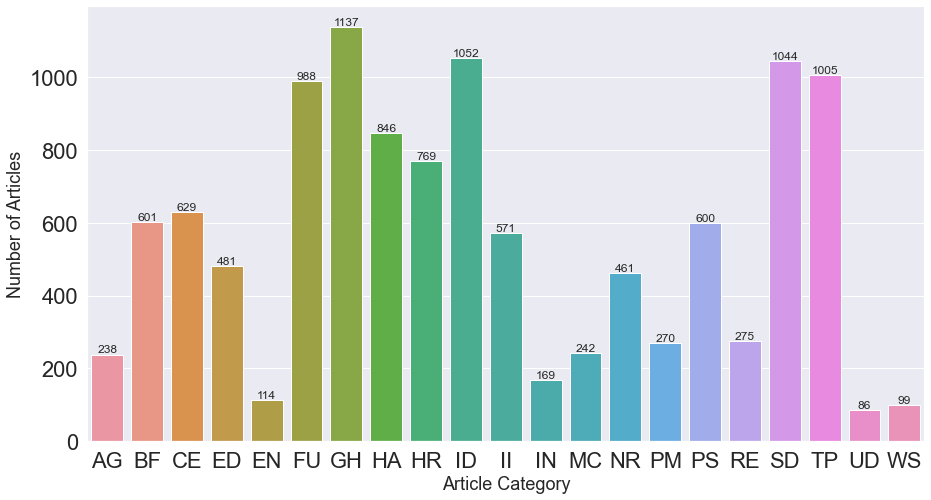

In [984]:
# save_path = "/Users/bradloff/Documents/masterthesis/thesis/graphics/augmented_articles_per_category.png"
categories = list(abbrev_mapping.keys())
print_label_frequencies(df, categories)

### Number of Labels

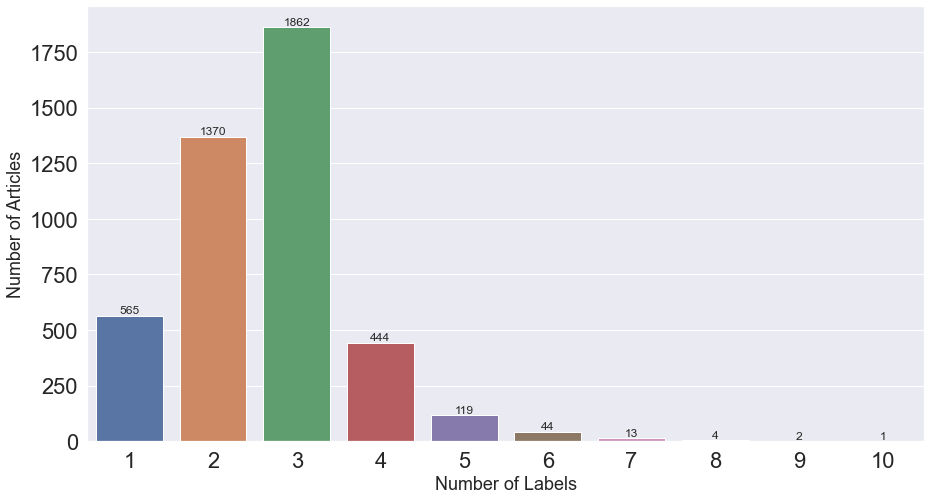

In [53]:
row_sums = df.loc[:,categories].sum(axis=1)
multilabel_counts = row_sums.value_counts().to_frame()
multilabel_counts["index"] = multilabel_counts.index
multilabel_counts.columns = ["amount", "index"]
multilabel_counts.sort_values(by="index", inplace=True)

sns.set(font_scale=2)
plt.figure(figsize=(15,8))

ax = sns.barplot(multilabel_counts["index"], multilabel_counts["amount"].values)

#plt.title("Articles with multiple Labels", fontsize=24)
plt.ylabel("Number of Articles", fontsize=18)
plt.xlabel("Number of Labels", fontsize=18)

rects = ax.patches
amount_labels = multilabel_counts.values
for rect, label in zip(rects, amount_labels):
    height = rect.get_height()
    ax.text(x=rect.get_x() + rect.get_width()/2, 
            y=height, 
            s=label[0], 
            ha="center", 
            va="bottom", 
            fontsize=12)
plt.savefig("/Users/bradloff/Documents/masterthesis/thesis/graphics/number_labels.png", format="png")
plt.show()

In [54]:
label_df = df.drop(labels=["id", "text"], axis=1)
unique_labels_df = label_df.drop_duplicates()
len(unique_labels_df)

1155

### Word Cloud

In [ ]:
label = "UD"
is_label = df.loc[:,label] == 1 
subset = df[is_label]
text = subset.text.values

plt.figure(figsize=(40,25))
cloud = WordCloud(
                    stopwords=STOPWORDS,
                    background_color="black",
                    collocations=False,
                    width=2500,
                    height=1800,
                ).generate(" ".join(text))

plt.axis("off")
plt.title(abbrev_mapping[label], fontsize=50)
plt.imshow(cloud)
plt.show()

### Token Length

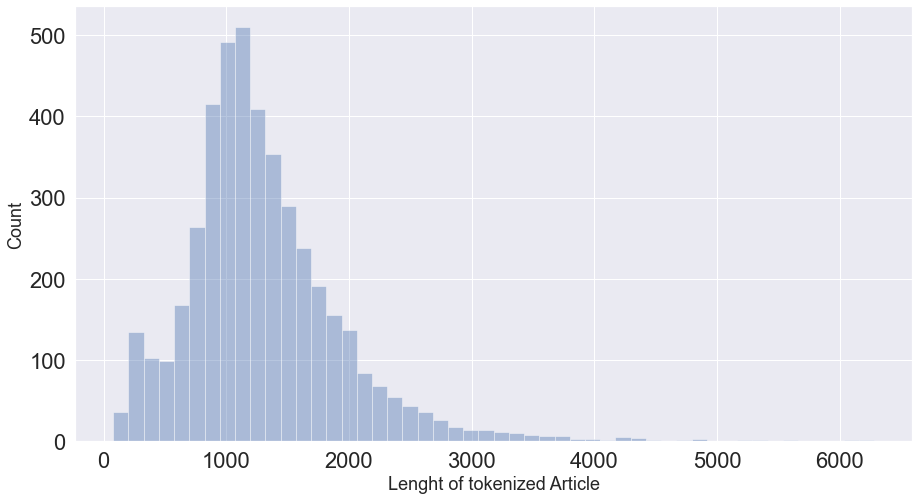

In [55]:
sns.set(font_scale=2)
plt.figure(figsize=(15,8))

lengths = np.array([len(input_id) for input_id in input_ids])
ax = sns.distplot(lengths, kde=False, norm_hist=False)
#plt.title("Distribution: Lenght of tokenized sentences", fontsize=24)
plt.xlabel("Lenght of tokenized Article", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.savefig("/Users/bradloff/Documents/masterthesis/thesis/graphics/histogram_tokens.png", format="png")
plt.show()

In [56]:
print("Median: {}".format(np.median(lengths)))
print("Mean: {}".format(lengths.mean()))
print("STD: {}".format(lengths.std()))
print("Minimum: {}".format(lengths.min()))
print("Maximum: {}".format(lengths.max()))

Median: 1190.5
Mean: 1300.2714737793851
STD: 639.1976260120616
Minimum: 78
Maximum: 6282


In [ ]:
for index, length in enumerate(lengths):
    if length > 300 and length < 350:
        print(index)

#### K80 Memory Constraints

In [ ]:
amount_splits_estimate = [length/150 for length in lengths]
too_long_for_k80 = sum(np.where(np.array(amount_splits_estimate)>30, 1, 0))
print("Number of articles not fitting into K80 memory (12GB): {}".format(too_long_for_k80))

### Correlation Matrix 

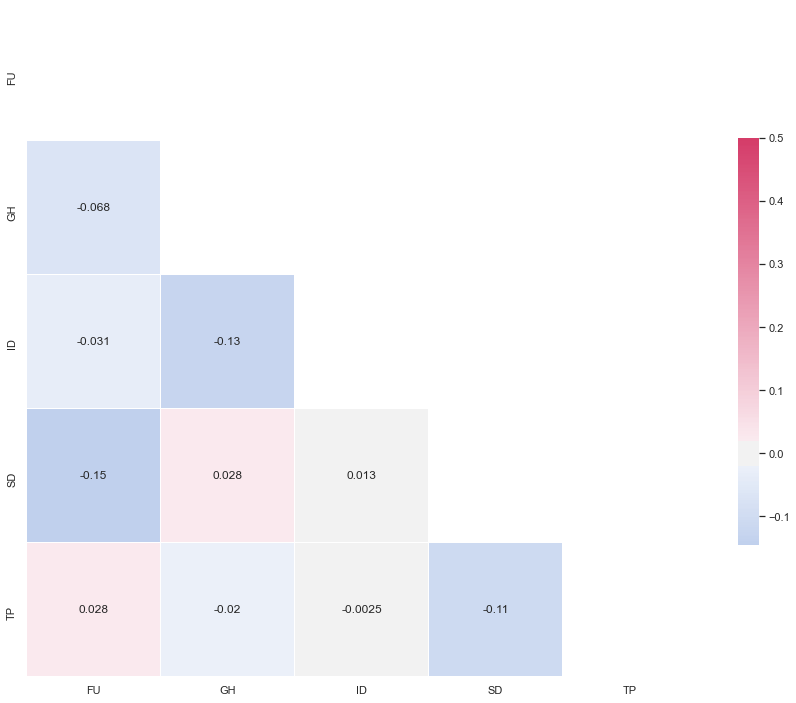

In [255]:
not_labels = ['AG', 'BF', 'CE', 'ED', 'EN', 'HA', 'HR', 'II', 'IN', 'MC', 'NR', 'PM', 'PS', 'RE', 'UD', 'WS']
correlation = df.drop(["id", "text"]+not_labels, axis=1).corr()
sns.set(style="whitegrid")
mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(15,15))
cmap = sns.diverging_palette(255,0, as_cmap=True)
sns.heatmap(correlation, mask=mask, cmap=cmap, vmax=0.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

#plt.savefig("/Users/bradloff/Documents/masterthesis/thesis/graphics/label_correlation.png", format="png")
plt.show()

## Unlabeled Dataset

In [ ]:
with open("../data/data_lm_devex_mw.txt") as all_data:
    all_articles = all_data.read()

In [ ]:
tokenezid_data = transformer.tokenizer.encode(all_articles)

In [ ]:
len(tokenezid_data)

### Summaries

In [ ]:
summary_df = pd.read_csv("../data/article_confirmed_roberta-lm_summary.csv")

In [ ]:
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)
for index, summary in enumerate(summary_df.summary_cluster.values):
    try:
        tokens = transformer.tokenizer(summary)
    except:
        print(index)
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.WARNING)

In [ ]:
with IncreasedLoggingLevel("transformers.tokenization_utils_base") as x:
    input_ids_cluster = [transformer.tokenizer(text) for text in tqdm(summary_df.summary_cluster.values)] 
    input_ids_textrank = [transformer.tokenizer(text) for text in tqdm(summary_df.summary_textrank.values)] 

In [ ]:
sns.set(font_scale=2)
plt.figure(figsize=(15,8))

lengths = np.array([len(tokenization["input_ids"]) for tokenization in input_ids_cluster])
ax = sns.distplot(lengths, kde=False, norm_hist=False)
#plt.title("Distribution: Lenght of tokenized sentences", fontsize=24)
plt.xlabel("Lenght of tokenized Article", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.savefig("/Users/bradloff/Documents/masterthesis/thesis/graphics/histogram_tokens_summary_cluster.png", format="png")
plt.show()

print("Median: {}".format(np.median(lengths)))
print("Mean: {}".format(lengths.mean()))
print("STD: {}".format(lengths.std()))
print("Minimum: {}".format(lengths.min()))
print("Maximum: {}".format(lengths.max()))

In [ ]:
sns.set(font_scale=2)
plt.figure(figsize=(15,8))

lengths = np.array([len(tokenization["input_ids"]) for tokenization in input_ids_textrank])
ax = sns.distplot(lengths, kde=False, norm_hist=False)
#plt.title("Distribution: Lenght of tokenized sentences", fontsize=24)
plt.xlabel("Lenght of tokenized Article", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.savefig("/Users/bradloff/Documents/masterthesis/thesis/graphics/histogram_tokens_summary_textrank.png", format="png")
plt.show()

print("Median: {}".format(np.median(lengths)))
print("Mean: {}".format(lengths.mean()))
print("STD: {}".format(lengths.std()))
print("Minimum: {}".format(lengths.min()))
print("Maximum: {}".format(lengths.max()))

# Data Split

In [ ]:
summary_df = pd.read_csv("../data/article_confirmed_summary.csv")

In [28]:
from sklearn.model_selection import train_test_split

In [30]:
for seed in range(5):
    df_train, df_eval = train_test_split(summary_df, test_size=0.2, random_state=seed)
    df_train.to_csv("../data/train-eval-split/{}/df_train_{}.csv".format(str(seed), str(seed)), index=False)
    df_eval.to_csv("../data/train-eval-split/{}/df_eval_{}.csv".format(str(seed), str(seed)), index=False)

In [96]:
top5_labels = ["FU", "GH", "ID", "SD", "TP"]

In [97]:
def restrict_labels(df, labels):
    return df.loc[:,["id","text", "summary_cluster", "summary_textrank"]+labels]

In [103]:
sum(restricted_df.iloc[0,:].loc[top5_labels].values)

0

In [104]:
def sum_labels(row):
    return sum(row.loc[top5_labels].values)

In [105]:
restricted_df = restrict_labels(summary_df, top5_labels)
restricted_df["number_active"] = restricted_df.apply(func=sum_labels,axis=1)

In [106]:
restricted_df["number_active"]

0       0
1       1
2       0
3       0
4       0
       ..
4419    1
4420    1
4421    3
4422    2
4423    1
Name: number_active, Length: 4424, dtype: int64

# Augmentation

In [530]:
translator = Translator()
languages = ["zh-cn", "de", "fi", "hi", "ar", "tr"]

In [531]:
aug_syn_ppdb = naw.SynonymAug(aug_src="ppdb",
                              model_path="aug_models/ppdb-2.0-s-all",
                              aug_max=None)

aug_syn_wordnet = naw.SynonymAug(aug_src="wordnet",
                                 aug_max=None)

In [9]:
summary_df = pd.read_csv("../data/article_confirmed_summary.csv")

In [290]:
augmentations_df = pd.read_csv("../data/article_confirmed_summary_augmentations.csv")

In [528]:
%run -i "../news-topic-cls/core/data/augmentation.py"

In [291]:
augmentations_df.head(2)

,augmentation_id,reference_id,augmented_article,augmented_summary_cluster,augmented_summary_textrank,AG,BF,CE,ED,EN,...,IN,MC,NR,PM,PS,RE,SD,TP,UD,WS
0,0,29186,Development jobs in Peru: What you require to ...,Information technology be insufferable to see ...,"What to fetch Once in Cuzco, surgery anyplace ...",0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,29186,Development jobs in Peru: What you need to kno...,Information technology was unacceptable to see...,"What to bring Once in Cuzco, or anywhere in Pe...",0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [313]:
for index, row in tqdm(augmentations_df.iterrows(), total=len(augmentations_df), position=0, leave=True):
    if "MISSING" in row.augmented_article and len(row.augmented_article.strip()) <= 13:
        original_text = summary_df[summary_df.id==row.reference_id].text.values[0]
        language = row.augmented_article.strip()[8:]
        try:
            backtrans = backtranslation(text=original_text, 
                                       translator=translator, 
                                       language=language)

            augmentations_df.loc[index, "augmented_article"] = backtrans
        except Exception as err:
            print("{}: ID {}; Augmentation: {} ; Article".format(err.__class__.__name__, row.reference_id, row.augmentation_id))
        
    if "MISSING" in row.augmented_summary_cluster and len(row.augmented_summary_cluster.strip()) <= 13:
        original_text = summary_df[summary_df.id==row.reference_id].summary_cluster.values[0]
        language = row.augmented_summary_cluster.strip()[8:]
        try:
            backtrans = backtranslation(text=original_text, 
                                       translator=translator, 
                                       language=language)

            augmentations_df.loc[index, "augmented_summary_cluster"] = backtrans
        except Exception as err:
            print("{}: ID {}; Augmentation: {} ; Summary Cluster".format(err.__class__.__name__, row.reference_id, row.augmentation_id))
            
    if "MISSING" in row.augmented_summary_textrank and len(row.augmented_summary_textrank.strip()) <= 13:
        original_text = summary_df[summary_df.id==row.reference_id].summary_textrank.values[0]
        language = row.augmented_summary_textrank.strip()[8:]
        try:
            backtrans = backtranslation(text=original_text, 
                                       translator=translator, 
                                       language=language)
            augmentations_df.loc[index, "augmented_summary_textrank"] = backtrans
        except Exception as err:
            print("{}: ID {}; Augmentation: {} ; Summary Textrank".format(err.__class__.__name__, row.reference_id, row.augmentation_id))

100%|██████████| 53076/53076 [00:07<00:00, 7487.89it/s]


In [314]:
augmentations_df.to_csv("../data/article_confirmed_summary_augmentations.csv", index=False)

In [303]:
id_ = 96050
augmentation = 11
text_type="summary_textrank"
lang = languages[augmentation - 6]
text = summary_df[summary_df.id == id_].loc[:,text_type].values[0]

In [304]:
text

'The road project adversely impacted the watershed in Honduras’ dry corridor by forcing additional sediment into the water supply, which the community was already struggling to keep clean to ensure sufficient water for human consumption, said San Antonio del Norte Mayor Eulalio Maldonado Moreno. He said that continuous water management allows the community to understand exactly how access to water impacts development, and how it can be retained and stored to ensure future security. With help from a watershed management program led by nonprofit Global Communities, San Antonio del Norte has mitigated the impact of the road construction and improved other aspects of its system to secure the water supply for the population. The project is part of a wider effort called the Dry Corridor Alliance, signed by the Honduran government and international partners in 2014, which aims to improve life in the poverty-prone area by reducing malnutrition, increasing access to water, and stimulating the l

In [305]:
filtered_df = augmentations_df[(augmentations_df.reference_id == id_) & (augmentations_df.augmentation_id==augmentation)]
aug_text = filtered_df.loc[:,"augmented_summary_textrank".format(text_type)].values[0]
aug_text

'MISSING tr '

In [312]:
start = time.time()
backtrans = backtranslation(text=text, 
                           translator=translator, 
                           language=lang)
stop = time.time()
print("TIME: {}".format(stop-start))
print("Augmentation: \n{}".format(backtrans))

TIME: 0.8134322166442871
Augmentation: 
Eulalio Maldonado Moreno, Mayor of San Antonio del Norte, said the road project negatively impacted the basin in Honduras' dry corridor, by forcing additional sediment into the water source that the community is already struggling to keep clean to provide enough water for human consumption. He said that continuous water management has allowed the community to fully understand how access to water affects development and how it can be contained and stored to ensure future safety. With the help of a watershed management program led by the nonprofit Global Communities, San Antonio del Norte reduced the impact of road construction and improved other aspects of its system to secure the population's water supply. The project is part of a broader effort signed by the Honduran government and international partners in 2014, called the Dry Corridor Alliance, which aims to improve life in the poverty-prone region by reducing malnutrition, increasing access t

In [319]:
duplicates = augmentations_df.duplicated(subset=["augmented_summary_textrank"], keep=False)

In [320]:
sum(duplicates.values)

11

### Explorative Analysis on augmented Dataset

In [988]:
def generate_augmentations(row, categories, label_counter):
    labels = row.loc[categories].values
    active_labels = label_counter[labels.astype(bool)]
    
    min_active = min(active_labels)
    max_overall = max(label_counter)
    
    augmented_df = pd.DataFrame(columns=["id", "text"] + categories)
    
    if max_overall in active_labels:
        return augmented_df
    
    number_augmentations = min(math.ceil(max_overall/min_active),12)
    
    augmented_text = ["test"] * number_augmentations
    
    augmented_ids = [int(str(row.id) + str(new_id)) for new_id in range(number_augmentations)]
    
    augmented_labels = np.array([list(labels),] * number_augmentations)
    
    
    augmented_df["id"] = augmented_ids
    augmented_df["text"] = augmented_text
    augmented_df[categories] = augmented_labels
    
    return augmented_df

categories = list(summary_df.drop(columns=["id", "text", "summary_cluster", "summary_textrank"]).columns)
categories = ["WS", "none_active"]
df_restricted = df
df_restricted.loc[:,"none_active"] = 0

def construct_none(row, categories=categories):
    if sum(row.loc[categories].values) == 0:
        row.none_active = 1
    return row

df_restricted = df_restricted.apply(func=construct_none, axis=1)
label_counter_original = df_restricted.loc[:, categories].sum().values
counter_dict = {category: counter for category,counter in zip(categories, label_counter_original)}
sorted_labels = sorted(categories, key=lambda key:counter_dict[key], reverse=False)
df_aug = df_restricted

for category in tqdm(sorted_labels, total=len(sorted_labels), position=0, leave=True):
    active_df = df_restricted[df_restricted.loc[:,category]==1]
    for index, row in active_df.iterrows():
        if int(str(row.id) + "0") not in df_aug.id.values:
            label_counter = df_aug.loc[:, categories].sum().values
            augmented_df = generate_augmentations(row, categories, label_counter)

            df_aug = pd.concat([df_aug, augmented_df])

100%|██████████| 2/2 [00:29<00:00, 14.59s/it]


Number of Datapoints: 5247


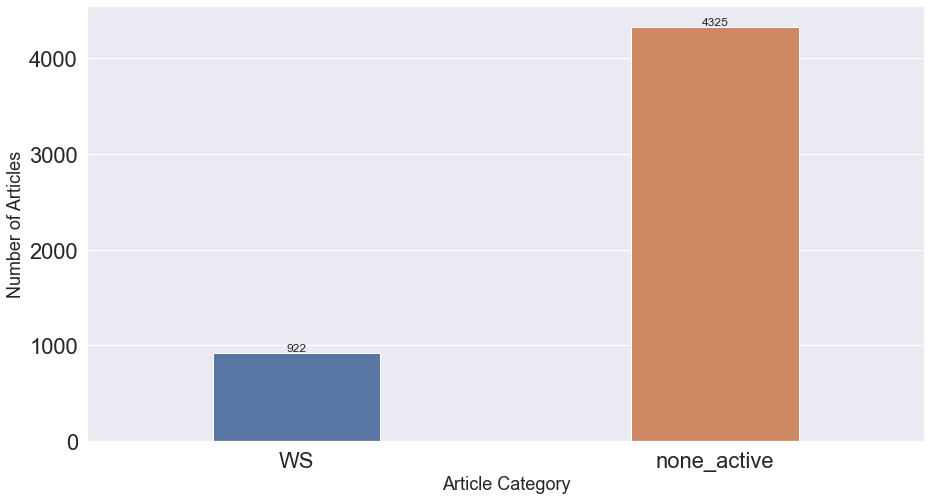

In [989]:
print_label_frequencies(df_aug, categories, save_path=None)

In [669]:
label_counter = df_aug.loc[:,categories].astype(int).sum().values

In [671]:
label_counter.std()

305.28929070704095

### Evaluate Augmentations on Training Sets

In [717]:
seed=3
number_labels=5

original_set_path = "../data/train-eval-split/{}/df_train_{}.csv".format(str(seed), str(seed))
aug_path = "../data/train-eval-split/{}/df_train_{}_augmented_{}labels.csv".format(str(seed), str(seed), str(number_labels))

In [718]:
train_df = pd.read_csv(original_set_path)
aug_df = pd.read_csv(aug_path)

In [715]:
categories = list(train_df.drop(columns=["id", "text", "summary_cluster", "summary_textrank"]).columns)

In [719]:
categories = ["GH", "FU", "TP", "ID", "SD"]

In [707]:
categories = ["GH"]

Number of Datapoints: 3958


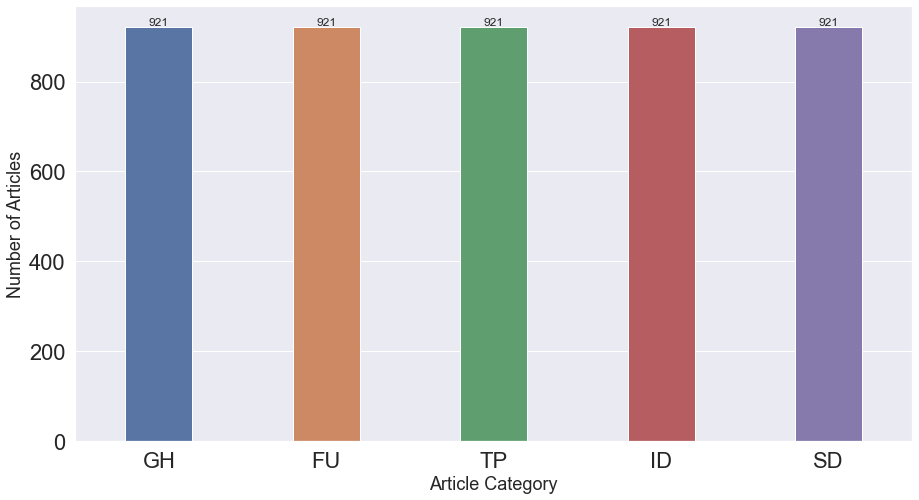

In [720]:
print_label_frequencies(aug_df, categories, save_path=None)